# LucidBench Benchmark Analysis

This notebook provides comprehensive analysis of filesystem benchmark results across different storage devices and filesystems.

## Table of Contents
1. [Setup and Data Loading](#setup)
2. [Overview and Summary Statistics](#overview)
3. [Performance Analysis by Storage Type](#storage-analysis)
4. [Filesystem Comparison](#filesystem-analysis)
5. [I/O Pattern Analysis](#io-analysis)
6. [Resource Utilization](#resource-analysis)
7. [Statistical Analysis](#statistical-analysis)
8. [Comparative Analysis](#comparative-analysis)
9. [Recommendations and Conclusions](#conclusions)

## 1. Setup and Data Loading <a name="setup"></a>

In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats
from pathlib import Path

# Set plot style
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

In [5]:
def load_benchmark_data(run_dir):
    """Load all benchmark and monitoring data from a run directory."""
    data = []
    
    for test_dir in Path(run_dir).glob('*'):
        if not test_dir.is_dir():
            continue
            
        # Parse test directory name
        parts = test_dir.name.split('_')
        if len(parts) < 4:
            continue
            
        storage_type = parts[0]
        device = parts[1]
        filesystem = parts[2]
        test_type = '_'.join(parts[3:])
        
        # Load test data
        test_file = test_dir / 'test.json'
        if test_file.exists():
            with open(test_file) as f:
                test_data = json.load(f)
                
                # Load monitoring data
                monitor_file = test_dir / 'monitoring.json'
                if monitor_file.exists():
                    with open(monitor_file) as f:
                        monitor_data = json.load(f)
                        
                        # Combine data
                        if 'test_data' in locals() and 'monitor_data' in locals():
                            data.append({
                                'storage_type': storage_type,
                                'device': device,
                                'filesystem': filesystem,
                                'test_type': test_type,
                                'test_data': test_data,
                                'monitor_data': monitor_data
                            })
    
    return pd.DataFrame(data)

# Load data from the most recent run
results_dir = Path('../results')
latest_run = max(results_dir.glob('run_*'), key=os.path.getctime)
df = load_benchmark_data(latest_run)
print(f"Loaded data from {latest_run.name}")

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

## 2. Overview and Summary Statistics <a name="overview"></a>

In [18]:
def extract_performance_metrics(row):
    """Extract key performance metrics from test data."""
    test_data = row['test_data']
    job = test_data['jobs'][0]
    
    metrics = {
        'iops': job['read']['iops'] if 'read' in job else job['write']['iops'],
        'bandwidth': job['read']['bw'] if 'read' in job else job['write']['bw'],
        'latency': job['read']['lat_ns']['mean'] if 'read' in job else job['write']['lat_ns']['mean'],
        'runtime': int(job['job options']['runtime']) if 'job options' in job and 'runtime' in job['job options'] else 0
    }
    
    return pd.Series(metrics)

# Extract performance metrics
performance_df = df.apply(extract_performance_metrics, axis=1)
df = pd.concat([df, performance_df], axis=1)

# Display summary statistics
print("\nSummary Statistics by Storage Type and Filesystem:")
summary = df.groupby(['storage_type', 'filesystem']).agg({
    'iops': ['mean', 'std', 'min', 'max'],
    'bandwidth': ['mean', 'std', 'min', 'max'],
    'latency': ['mean', 'std', 'min', 'max']
}).round(2)
display(summary)


Summary Statistics by Storage Type and Filesystem:


iops                            bandwidth                                  latency                                
                             mean       std  min        max       mean         std  min        max         mean          std  min           max
storage_type filesystem                                                                                                                        
HDD          ext4          117.73    137.09  0.0     257.16   54981.25   109278.24  0.0   218897.0  68501749.01  79763077.58  0.0  1.495830e+08
             xfs           129.39    151.25  0.0     287.59   59159.75   117554.08  0.0   235489.0  62573485.35  73138138.45  0.0  1.390358e+08
NVMe         ext4        31840.79  62082.89  0.0  124949.48  742849.00  1176336.14  0.0  2471599.0   3358541.68   6548081.36  0.0  1.317901e+07
             xfs         32276.87  62798.75  0.0  126456.34  805146.00  1295213.63  0.0  2714759.0   3060966.70   5954982.34  0.0  1.199166e+07
SSD          ext4         4378.97   8484.46  0.0   17102.30  122976.00   202924.80  0.0   423495.0  19791720.28  38347482.57  0.0  7.729776e+07
             xfs          5017.60   9697.00  0.0   19558.61  150581.25   251722.79  0.0   524091.0  16018498.00  30957104.73  0.0  6.243977e+07

## 3. Performance Analysis by Storage Type <a name="storage-analysis"></a>

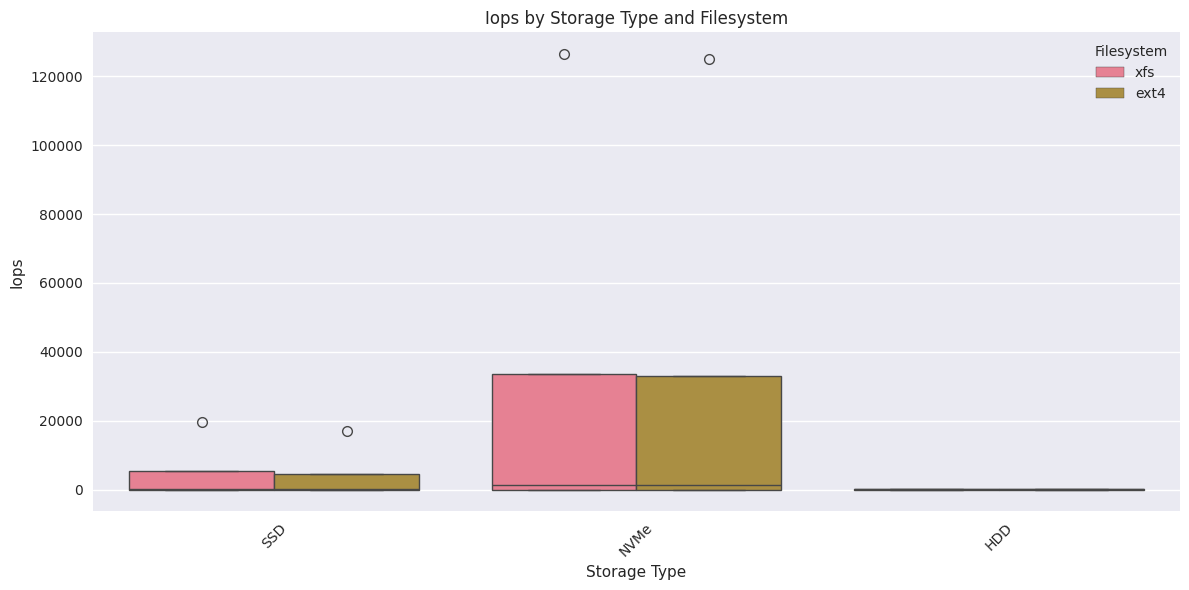

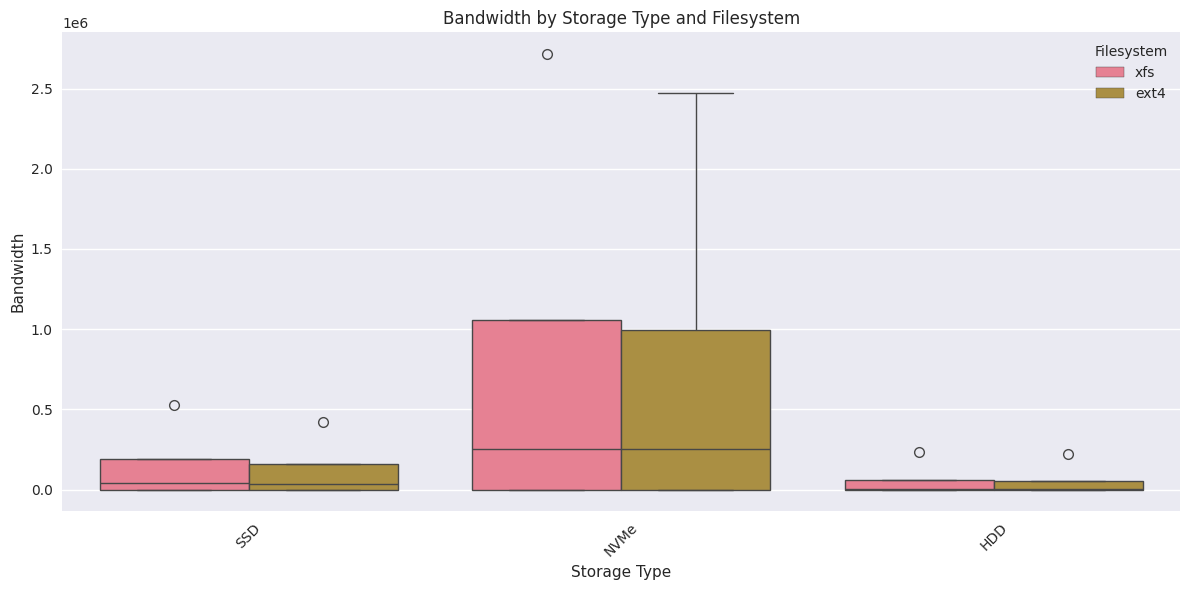

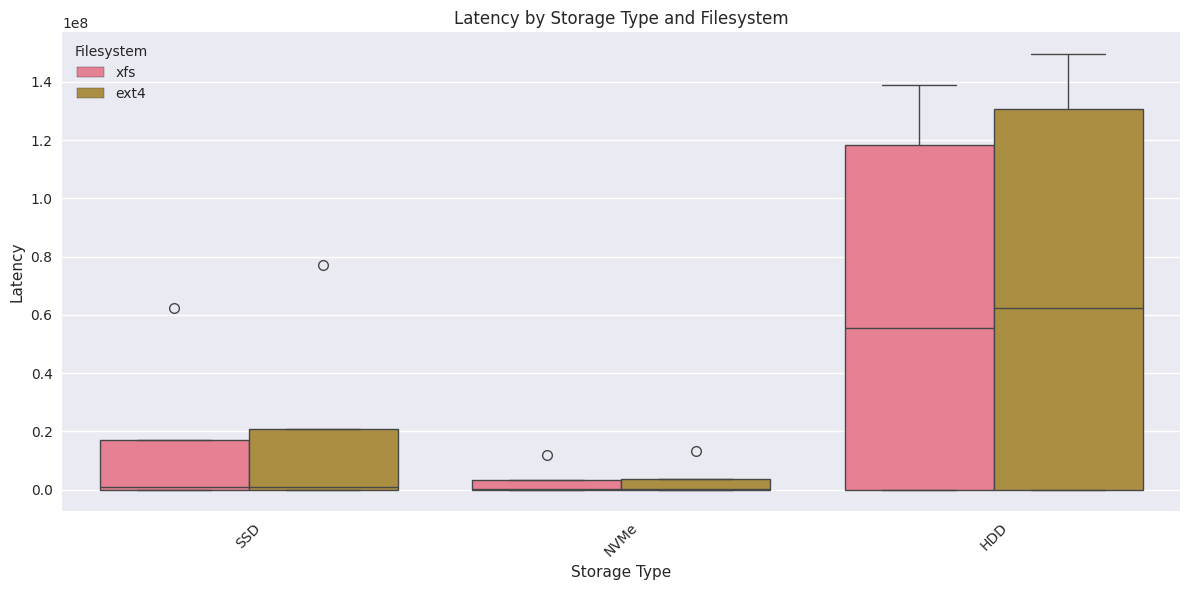

In [19]:
def plot_storage_performance(df, metric):
    """Plot performance metrics by storage type."""
    plt.figure(figsize=(12, 6))
    
    # Create box plot
    sns.boxplot(data=df, x='storage_type', y=metric, hue='filesystem')
    
    plt.title(f'{metric.title()} by Storage Type and Filesystem')
    plt.xlabel('Storage Type')
    plt.ylabel(metric.title())
    plt.xticks(rotation=45)
    plt.legend(title='Filesystem')
    plt.tight_layout()
    plt.show()

# Plot performance metrics
for metric in ['iops', 'bandwidth', 'latency']:
    plot_storage_performance(df, metric)

## 4. Filesystem Comparison <a name="filesystem-analysis"></a>


IOPS Comparison:


filesystem                              ext4            xfs
storage_type test_type                                     
HDD          random_read          257.157107     287.585611
             random_write           0.000000       0.000000
             sequential_read      213.767549     229.970243
             sequential_write       0.000000       0.000000
NVMe         random_read       124949.475691  126456.343464
             random_write           0.000000       0.000000
             sequential_read     2413.671184    2651.132686
             sequential_write       0.000000       0.000000
SSD          random_read        17102.296451   19558.606282
             random_write           0.000000       0.000000
             sequential_read      413.570275     511.808072
             sequential_write       0.000000       0.000000

<Figure size 1200x600 with 0 Axes>

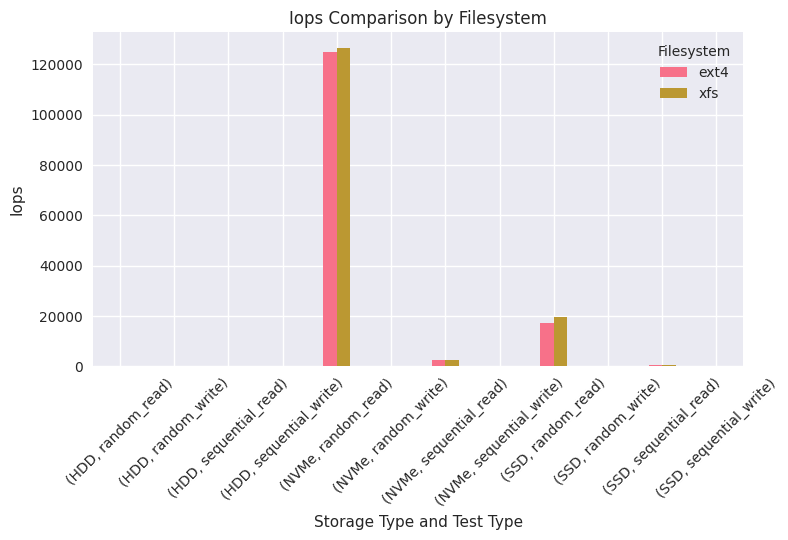


BANDWIDTH Comparison:


filesystem                          ext4        xfs
storage_type test_type                             
HDD          random_read          1028.0     1150.0
             random_write            0.0        0.0
             sequential_read    218897.0   235489.0
             sequential_write        0.0        0.0
NVMe         random_read        499797.0   505825.0
             random_write            0.0        0.0
             sequential_read   2471599.0  2714759.0
             sequential_write        0.0        0.0
SSD          random_read         68409.0    78234.0
             random_write            0.0        0.0
             sequential_read    423495.0   524091.0
             sequential_write        0.0        0.0

<Figure size 1200x600 with 0 Axes>

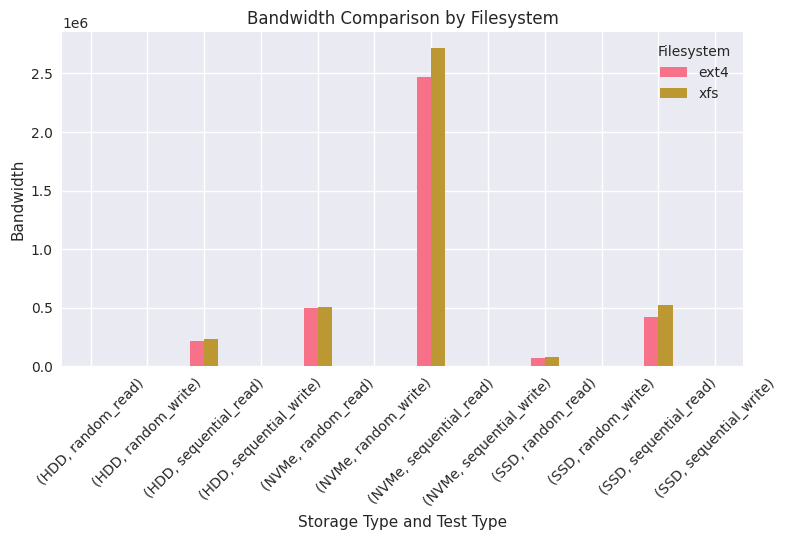


LATENCY Comparison:


filesystem                             ext4           xfs
storage_type test_type                                   
HDD          random_read       1.244240e+08  1.112582e+08
             random_write      0.000000e+00  0.000000e+00
             sequential_read   1.495830e+08  1.390358e+08
             sequential_write  0.000000e+00  0.000000e+00
NVMe         random_read       2.551603e+05  2.522070e+05
             random_write      0.000000e+00  0.000000e+00
             sequential_read   1.317901e+07  1.199166e+07
             sequential_write  0.000000e+00  0.000000e+00
SSD          random_read       1.869123e+06  1.634217e+06
             random_write      0.000000e+00  0.000000e+00
             sequential_read   7.729776e+07  6.243977e+07
             sequential_write  0.000000e+00  0.000000e+00

<Figure size 1200x600 with 0 Axes>

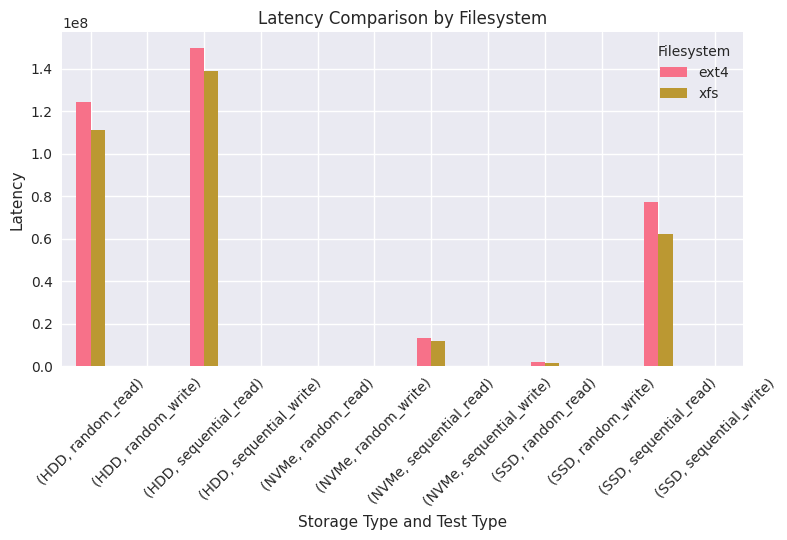

In [20]:
def analyze_filesystem_performance(df):
    """Analyze filesystem performance across different test types."""
    # Create pivot table for each metric
    metrics = ['iops', 'bandwidth', 'latency']
    
    for metric in metrics:
        pivot = pd.pivot_table(
            df,
            values=metric,
            index=['storage_type', 'test_type'],
            columns='filesystem',
            aggfunc='mean'
        )
        
        print(f"\n{metric.upper()} Comparison:")
        display(pivot)
        
        # Plot comparison
        plt.figure(figsize=(12, 6))
        pivot.plot(kind='bar')
        plt.title(f'{metric.title()} Comparison by Filesystem')
        plt.xlabel('Storage Type and Test Type')
        plt.ylabel(metric.title())
        plt.xticks(rotation=45)
        plt.legend(title='Filesystem')
        plt.tight_layout()
        plt.show()

analyze_filesystem_performance(df)

## 5. I/O Pattern Analysis <a name="io-analysis"></a>


I/O Pattern Statistics:


iops                                bandwidth                                       latency                                        
                      mean       std     min        max        mean         std       min        max         mean          std          min           max
test_type                                                                                                                                                
random_read       48101.91  60656.40  257.16  126456.34   192407.17   242625.47    1028.0   505825.0  39948814.09  60482328.62    252207.04  1.244240e+08
random_write          0.00      0.00    0.00       0.00        0.00        0.00       0.0        0.0         0.00         0.00         0.00  0.000000e+00
sequential_read    1072.32   1139.01  213.77    2651.13  1098055.00  1166341.26  218897.0  2714759.0  75587826.59  59356641.08  11991659.77  1.495830e+08
sequential_write      0.00      0.00    0.00       0.00        0.00        0.00       0.0        0.0         0.00         0.00         0.00  0.000000e+00

/tmp/ipykernel_126306/2355957436.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)
/tmp/ipykernel_126306/2355957436.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=45)
/tmp/ipykernel_126306/2355957436.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=45)


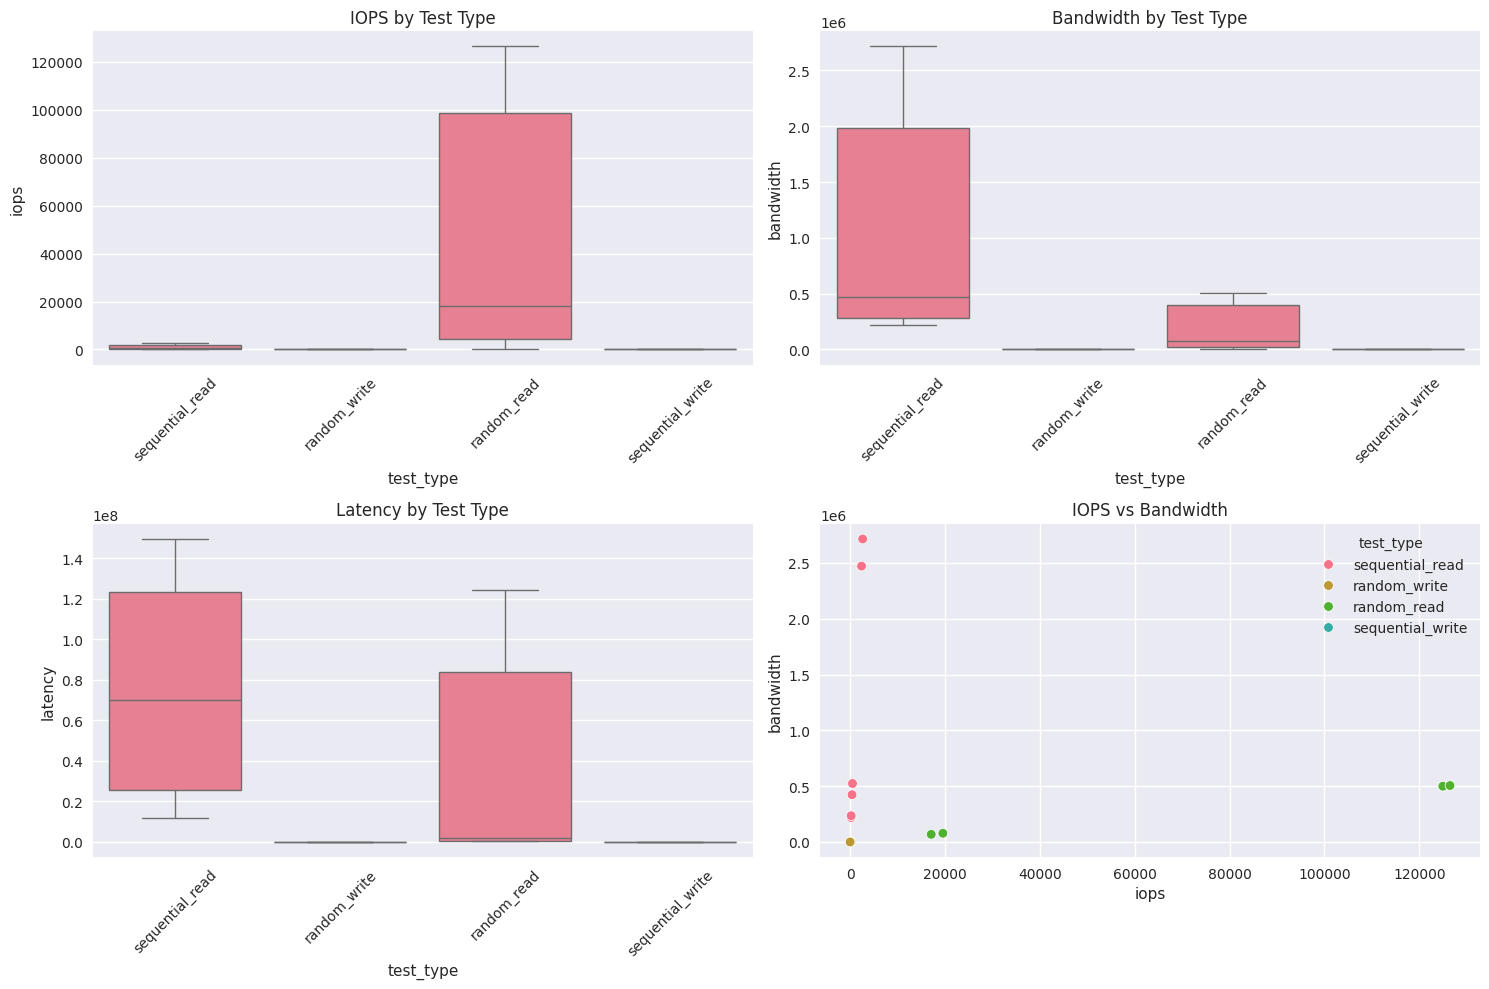

In [21]:
def analyze_io_patterns(df):
    """Analyze I/O patterns across different test types."""
    # Group by test type and calculate statistics
    io_stats = df.groupby('test_type').agg({
        'iops': ['mean', 'std', 'min', 'max'],
        'bandwidth': ['mean', 'std', 'min', 'max'],
        'latency': ['mean', 'std', 'min', 'max']
    }).round(2)
    
    print("\nI/O Pattern Statistics:")
    display(io_stats)
    
    # Plot I/O patterns
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # IOPS by test type
    sns.boxplot(data=df, x='test_type', y='iops', ax=axes[0,0])
    axes[0,0].set_title('IOPS by Test Type')
    axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)
    
    # Bandwidth by test type
    sns.boxplot(data=df, x='test_type', y='bandwidth', ax=axes[0,1])
    axes[0,1].set_title('Bandwidth by Test Type')
    axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=45)
    
    # Latency by test type
    sns.boxplot(data=df, x='test_type', y='latency', ax=axes[1,0])
    axes[1,0].set_title('Latency by Test Type')
    axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=45)
    
    # IOPS vs Bandwidth scatter
    sns.scatterplot(data=df, x='iops', y='bandwidth', hue='test_type', ax=axes[1,1])
    axes[1,1].set_title('IOPS vs Bandwidth')
    
    plt.tight_layout()
    plt.show()

analyze_io_patterns(df)

## 6. Resource Utilization <a name="resource-analysis"></a>

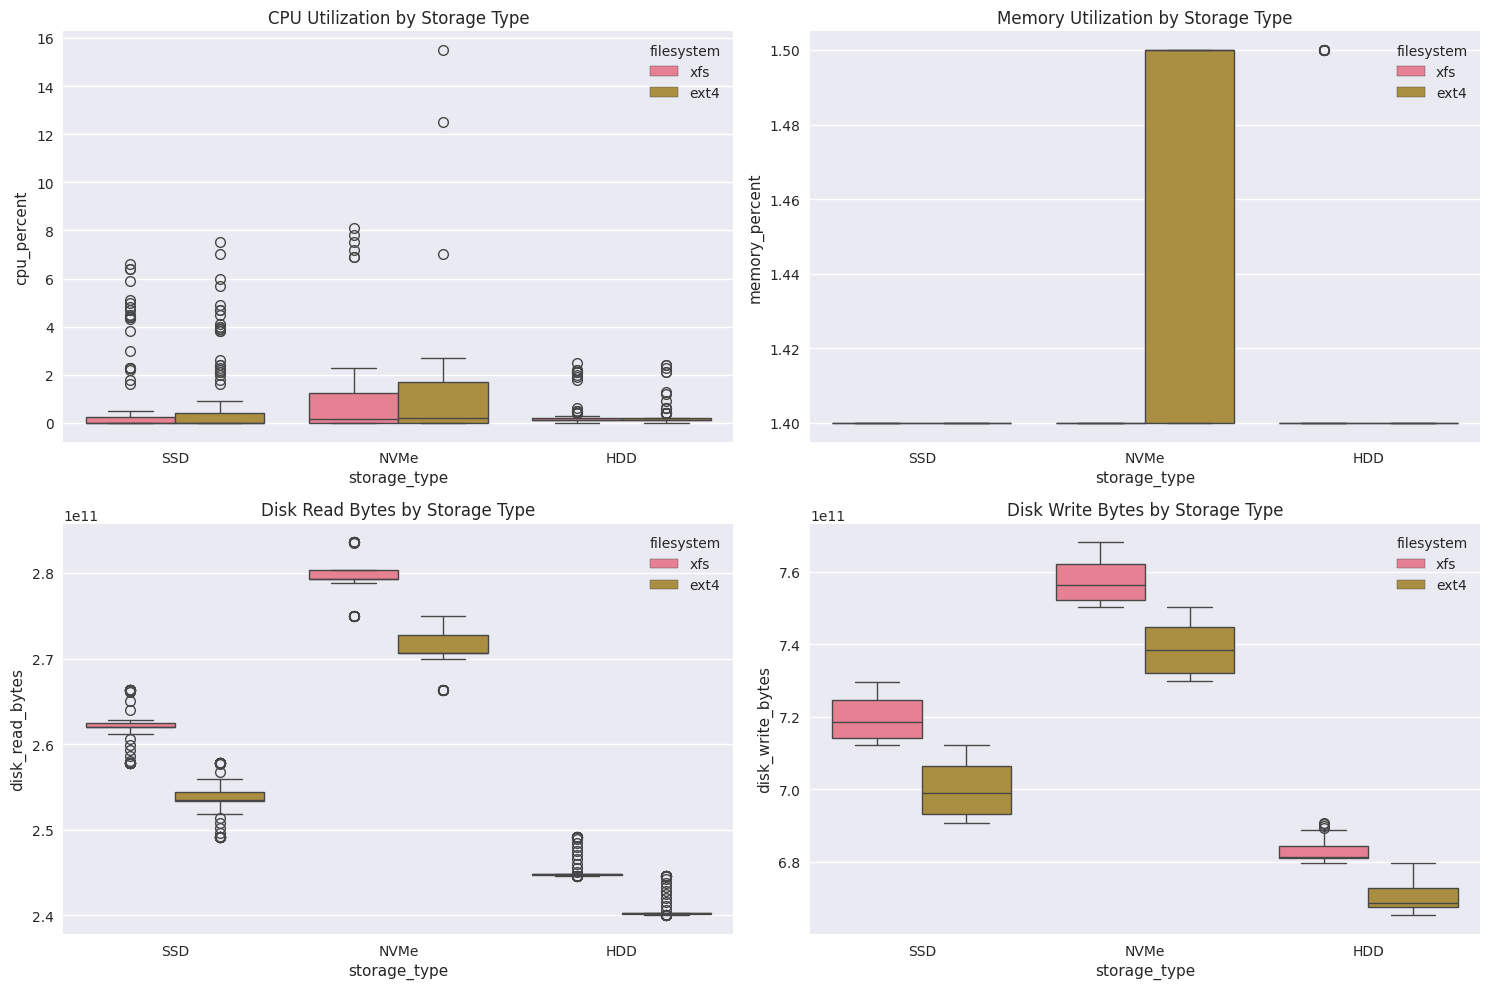

In [22]:
def analyze_resource_utilization(df):
    """Analyze system resource utilization during benchmarks."""
    # Extract monitoring data
    monitor_data = []
    for _, row in df.iterrows():
        for stat in row['monitor_data']['stats']:
            monitor_data.append({
                'storage_type': row['storage_type'],
                'filesystem': row['filesystem'],
                'test_type': row['test_type'],
                'timestamp': stat['timestamp'],
                'cpu_percent': stat['cpu_percent'],
                'memory_percent': stat['memory_percent'],
                'disk_read_bytes': stat['disk_read_bytes'],
                'disk_write_bytes': stat['disk_write_bytes']
            })
    
    monitor_df = pd.DataFrame(monitor_data)
    
    # Plot resource utilization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # CPU utilization
    sns.boxplot(data=monitor_df, x='storage_type', y='cpu_percent', hue='filesystem', ax=axes[0,0])
    axes[0,0].set_title('CPU Utilization by Storage Type')
    
    # Memory utilization
    sns.boxplot(data=monitor_df, x='storage_type', y='memory_percent', hue='filesystem', ax=axes[0,1])
    axes[0,1].set_title('Memory Utilization by Storage Type')
    
    # Disk read bytes
    sns.boxplot(data=monitor_df, x='storage_type', y='disk_read_bytes', hue='filesystem', ax=axes[1,0])
    axes[1,0].set_title('Disk Read Bytes by Storage Type')
    
    # Disk write bytes
    sns.boxplot(data=monitor_df, x='storage_type', y='disk_write_bytes', hue='filesystem', ax=axes[1,1])
    axes[1,1].set_title('Disk Write Bytes by Storage Type')
    
    plt.tight_layout()
    plt.show()

analyze_resource_utilization(df)

## 7. Statistical Analysis <a name="statistical-analysis"></a>


ANOVA Test for IOPS:
Storage Type ANOVA: F-statistic = 2.10, p-value = 0.1478
Filesystem ANOVA: F-statistic = 0.00, p-value = 0.9806

Correlation Matrix for iops:


,iops,bandwidth,latency
iops,1.000000,0.081036,-0.196680
bandwidth,0.081036,1.000000,-0.031587
latency,-0.196680,-0.031587,1.000000


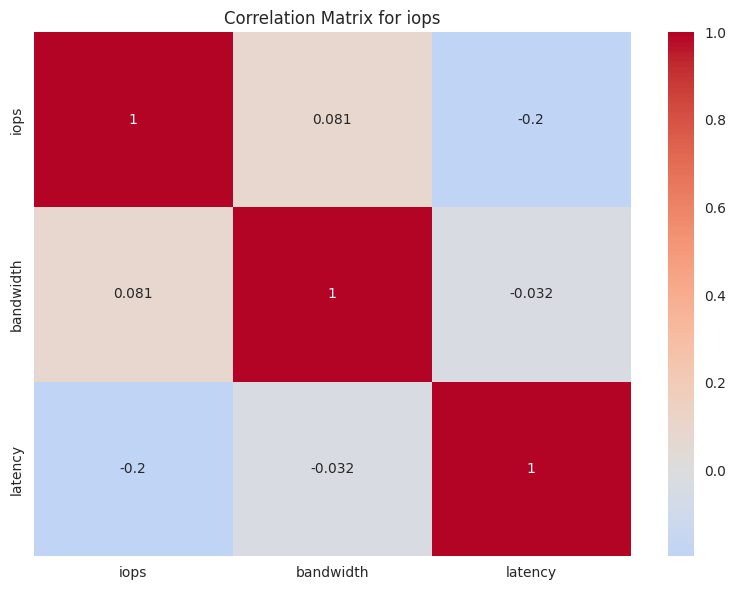


ANOVA Test for BANDWIDTH:
Storage Type ANOVA: F-statistic = 2.71, p-value = 0.0900
Filesystem ANOVA: F-statistic = 0.01, p-value = 0.9183

Correlation Matrix for bandwidth:


,iops,bandwidth,latency
iops,1.000000,0.081036,-0.196680
bandwidth,0.081036,1.000000,-0.031587
latency,-0.196680,-0.031587,1.000000


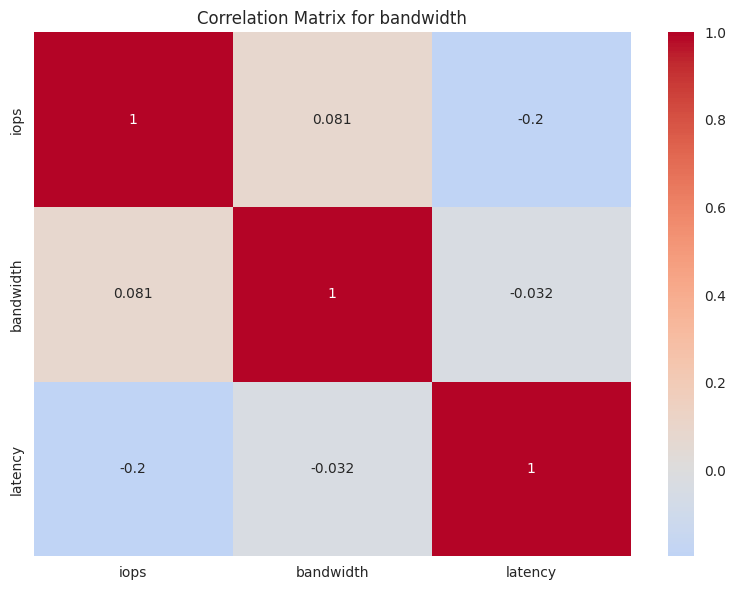


ANOVA Test for LATENCY:
Storage Type ANOVA: F-statistic = 4.17, p-value = 0.0298
Filesystem ANOVA: F-statistic = 0.02, p-value = 0.8769

Correlation Matrix for latency:


,iops,bandwidth,latency
iops,1.000000,0.081036,-0.196680
bandwidth,0.081036,1.000000,-0.031587
latency,-0.196680,-0.031587,1.000000


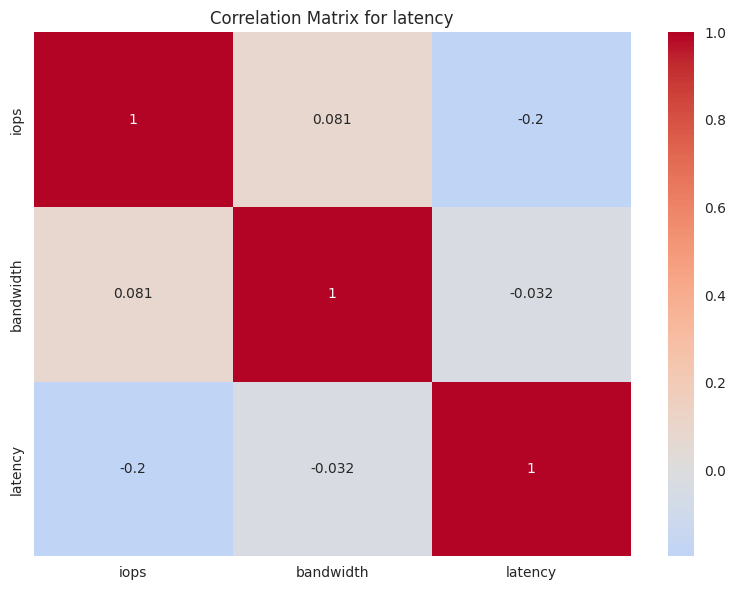

In [23]:
def perform_statistical_analysis(df):
    """Perform statistical analysis on benchmark results."""
    # ANOVA test for each metric
    metrics = ['iops', 'bandwidth', 'latency']
    
    for metric in metrics:
        print(f"\nANOVA Test for {metric.upper()}:")
        
        # Test by storage type
        storage_groups = [group for _, group in df.groupby('storage_type')[metric]]
        f_stat, p_val = stats.f_oneway(*storage_groups)
        print(f"Storage Type ANOVA: F-statistic = {f_stat:.2f}, p-value = {p_val:.4f}")
        
        # Test by filesystem
        fs_groups = [group for _, group in df.groupby('filesystem')[metric]]
        f_stat, p_val = stats.f_oneway(*fs_groups)
        print(f"Filesystem ANOVA: F-statistic = {f_stat:.2f}, p-value = {p_val:.4f}")
        
        # Correlation analysis
        corr_matrix = df[metrics].corr()
        print(f"\nCorrelation Matrix for {metric}:")
        display(corr_matrix)
        
        # Plot correlation heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title(f'Correlation Matrix for {metric}')
        plt.tight_layout()
        plt.show()

perform_statistical_analysis(df)

## 8. Comparative Analysis <a name="comparative-analysis"></a>


IOPS Comparison by Storage Type:


storage_type,HDD,NVMe,SSD
test_type,,,
random_read,272.371359,125702.909578,18330.451366
random_write,0.000000,0.000000,0.000000
sequential_read,221.868896,2532.401935,462.689173
sequential_write,0.000000,0.000000,0.000000



IOPS Comparison by Filesystem:


filesystem,ext4,xfs
test_type,,
random_read,47436.309750,48767.511786
random_write,0.000000,0.000000
sequential_read,1013.669669,1130.970334
sequential_write,0.000000,0.000000


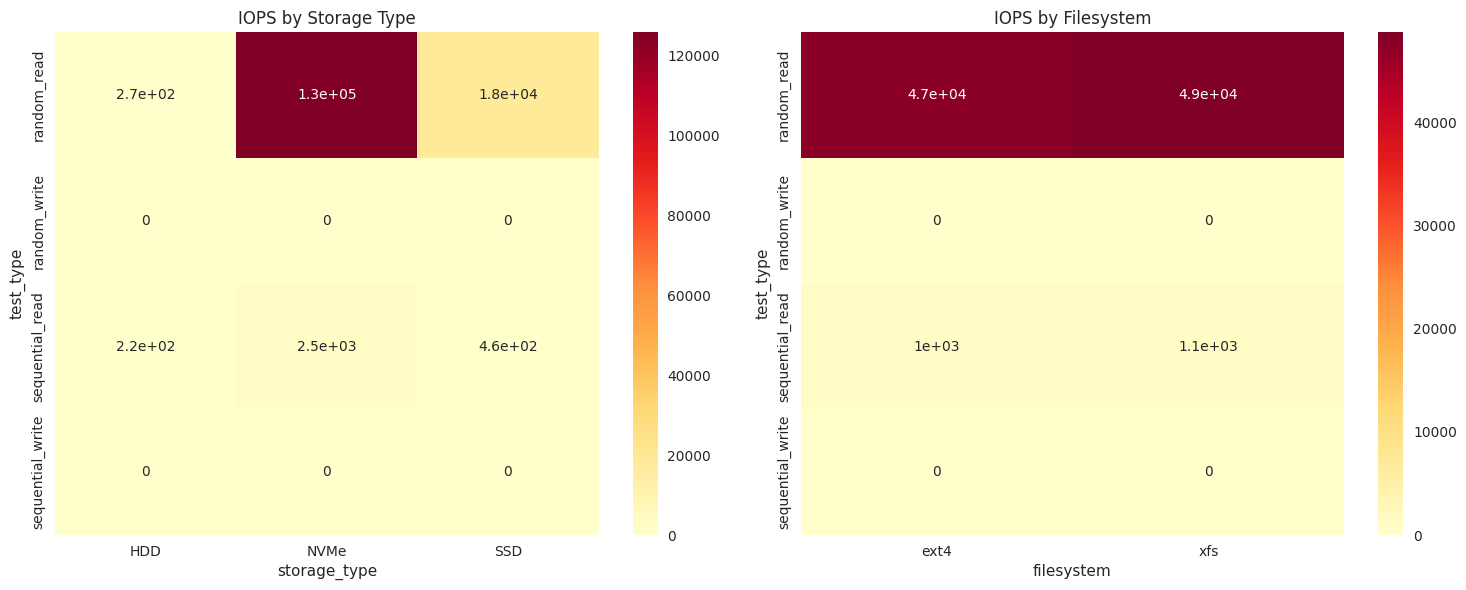


BANDWIDTH Comparison by Storage Type:


storage_type,HDD,NVMe,SSD
test_type,,,
random_read,1089.0,502811.0,73321.5
random_write,0.0,0.0,0.0
sequential_read,227193.0,2593179.0,473793.0
sequential_write,0.0,0.0,0.0



BANDWIDTH Comparison by Filesystem:


filesystem,ext4,xfs
test_type,,
random_read,1.897447e+05,1.950697e+05
random_write,0.000000e+00,0.000000e+00
sequential_read,1.037997e+06,1.158113e+06
sequential_write,0.000000e+00,0.000000e+00


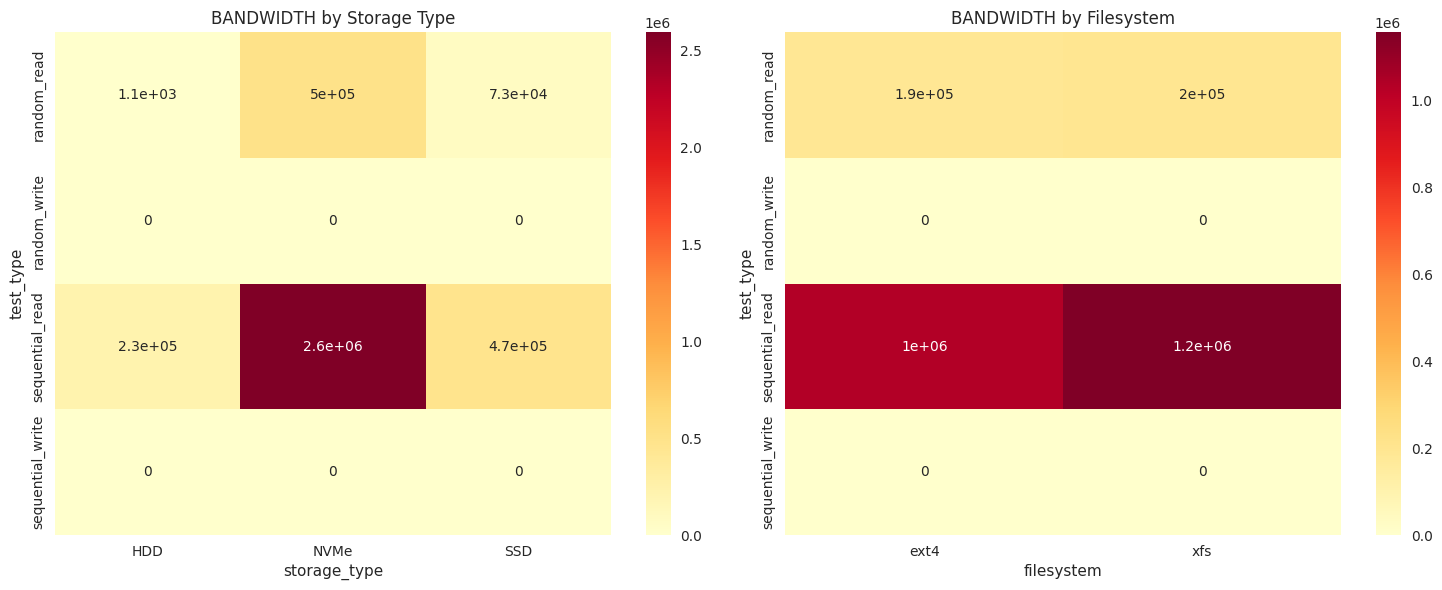


LATENCY Comparison by Storage Type:


storage_type,HDD,NVMe,SSD
test_type,,,
random_read,1.178411e+08,2.536837e+05,1.751670e+06
random_write,0.000000e+00,0.000000e+00,0.000000e+00
sequential_read,1.443094e+08,1.258533e+07,6.986877e+07
sequential_write,0.000000e+00,0.000000e+00,0.000000e+00



LATENCY Comparison by Filesystem:


filesystem,ext4,xfs
test_type,,
random_read,4.218276e+07,3.771486e+07
random_write,0.000000e+00,0.000000e+00
sequential_read,8.001992e+07,7.115574e+07
sequential_write,0.000000e+00,0.000000e+00


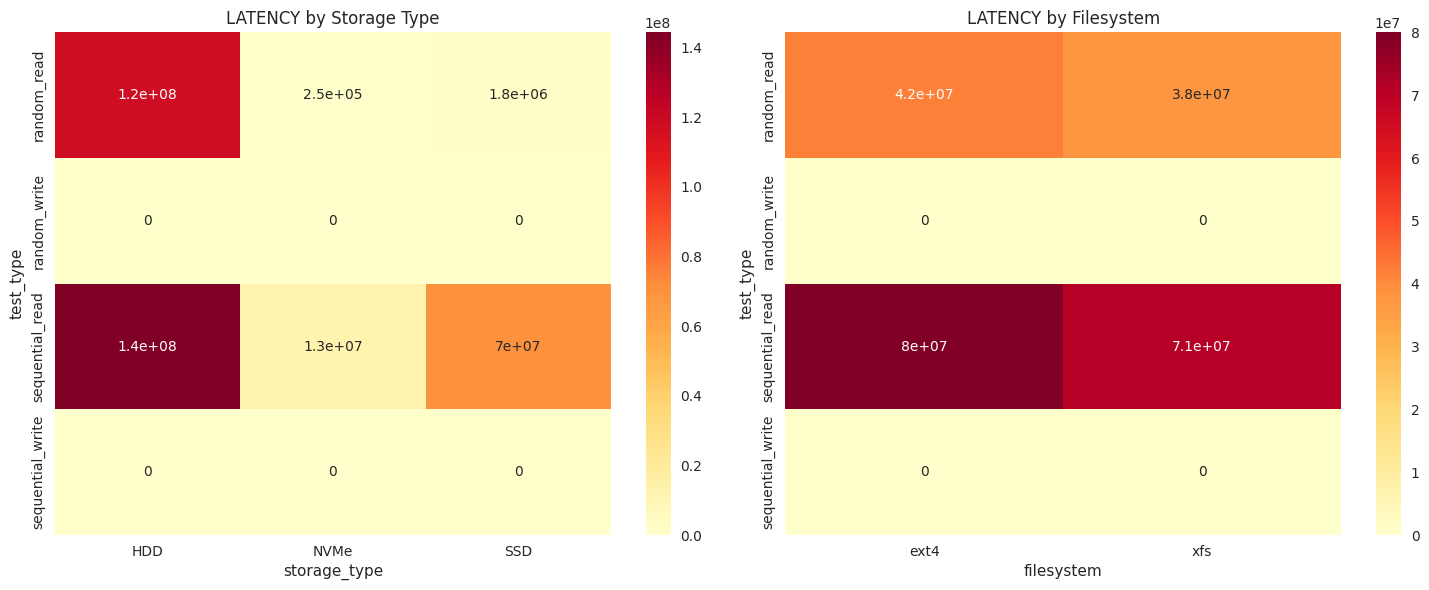

In [24]:
def perform_comparative_analysis(df):
    """Perform comparative analysis between different configurations."""
    # Create comparison matrix
    metrics = ['iops', 'bandwidth', 'latency']
    
    for metric in metrics:
        # Compare storage types
        storage_comparison = pd.pivot_table(
            df,
            values=metric,
            index='test_type',
            columns='storage_type',
            aggfunc='mean'
        )
        
        print(f"\n{metric.upper()} Comparison by Storage Type:")
        display(storage_comparison)
        
        # Compare filesystems
        fs_comparison = pd.pivot_table(
            df,
            values=metric,
            index='test_type',
            columns='filesystem',
            aggfunc='mean'
        )
        
        print(f"\n{metric.upper()} Comparison by Filesystem:")
        display(fs_comparison)
        
        # Plot comparison heatmaps
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        sns.heatmap(storage_comparison, annot=True, cmap='YlOrRd', ax=ax1)
        ax1.set_title(f'{metric.upper()} by Storage Type')
        
        sns.heatmap(fs_comparison, annot=True, cmap='YlOrRd', ax=ax2)
        ax2.set_title(f'{metric.upper()} by Filesystem')
        
        plt.tight_layout()
        plt.show()

perform_comparative_analysis(df)

## 9. Recommendations and Conclusions <a name="conclusions"></a>


Performance Scores and Recommendations:


performance_score     iops  bandwidth      latency
storage_type filesystem                                                    
HDD          ext4                    -0.11   121.86   54830.75  66671498.55
             xfs                     -0.10   129.66   59174.00  62467242.19
SSD          ext4                     0.10  3868.37  120774.25  19882375.77
             xfs                      0.15  5030.34  150567.00  16024460.74

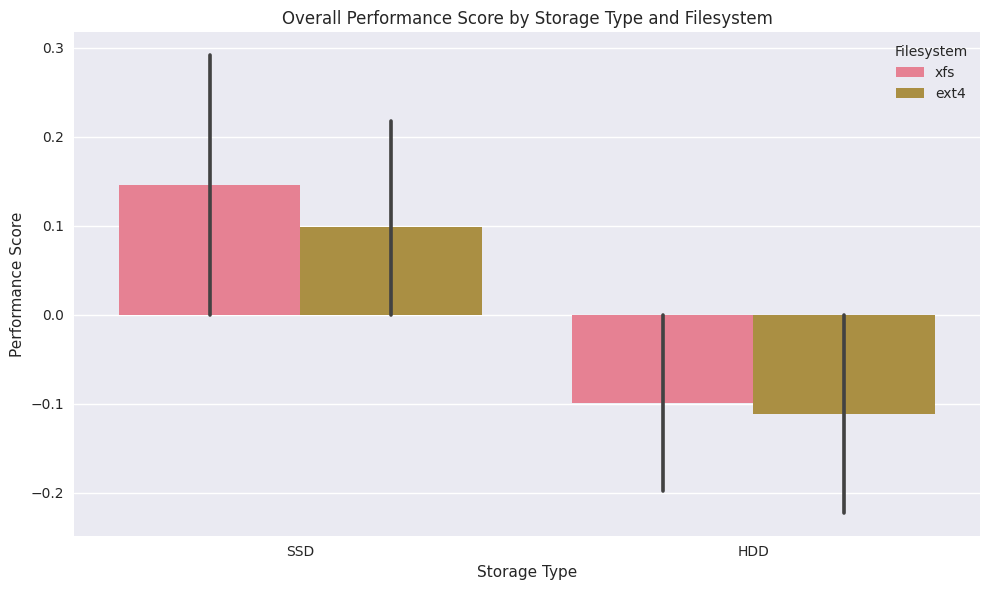

In [15]:
def generate_recommendations(df):
    """Generate recommendations based on benchmark results."""
    # Calculate performance scores
    df['performance_score'] = (
        df['iops'] / df['iops'].max() +
        df['bandwidth'] / df['bandwidth'].max() -
        df['latency'] / df['latency'].max()
    ) / 3
    
    # Group by storage type and filesystem
    recommendations = df.groupby(['storage_type', 'filesystem']).agg({
        'performance_score': 'mean',
        'iops': 'mean',
        'bandwidth': 'mean',
        'latency': 'mean'
    }).round(2)
    
    print("\nPerformance Scores and Recommendations:")
    display(recommendations)
    
    # Plot performance scores
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x='storage_type', y='performance_score', hue='filesystem')
    plt.title('Overall Performance Score by Storage Type and Filesystem')
    plt.xlabel('Storage Type')
    plt.ylabel('Performance Score')
    plt.legend(title='Filesystem')
    plt.tight_layout()
    plt.show()

generate_recommendations(df)